# This is a script for managing initial conditions (ICs) for simulations in Arepo2.

In [1]:
import os
cwd = os.getcwd()
print(cwd)

import numpy as np
import matplotlib.pyplot as plt
import h5py
from ic_tools import *
import shutil

/cosma/home/dp058/dc-faes1/scripts/ArepoISM_tools/pNbody_ics


# Set model parameters in yaml files, then

# Generate initial conditions with 'make_many_ics.sh'

In [ ]:
# set corresponding parameters for model sizes
# [V1-V4, V5-V8, V9-V12, V13-V16]
boxsizes = np.array([1000, 1500, 2000, 2000])
bh_masses = np.array([0.316, 1, 3.16, 10]) * 1e6  # in Msun
radii = np.array([20, 25, 30, 40]) # in kpc
heights = np.array([1, 1, 1, 1.5]) # in kpc

# [V1-2, V3-4, V5-6, V7-8, V9-10, V11-12, V13-14, V15-16]
resolutions = [600, 600, 2000, 2000, 3000, 6000, 10000, 20000] # Msun

# set paths
ic_path = '/cosma8/data/dp058/dc-faes1/initial_conditions/'
run_path = '/cosma8/data/dp058/dc-faes1/arepo2_base/'


Processing V1...

Check new file header:
BoxSize 1000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [ 584999  486666 1053333       0       0       0]
NumPart_Total [ 584999  486666 1053333       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V1.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V1.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V1/V1.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 3459719.93 Msun. Percentage of galaxy gas mass: 0.9857%
Hacky black hole fi

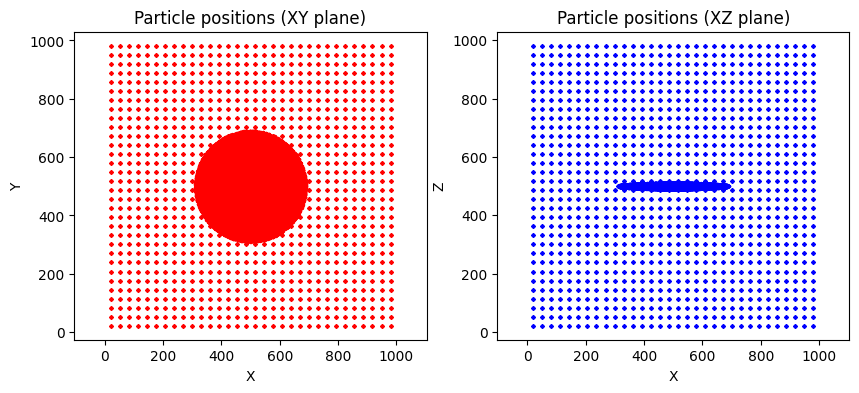


Processing V2...

Check new file header:
BoxSize 1000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [ 584999  486666 1055333       0       0       0]
NumPart_Total [ 584999  486666 1055333       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V2.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V2.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V2/V2.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 3459719.93 Msun. Percentage of galaxy gas mass: 0.9857%
Hacky black hole fi

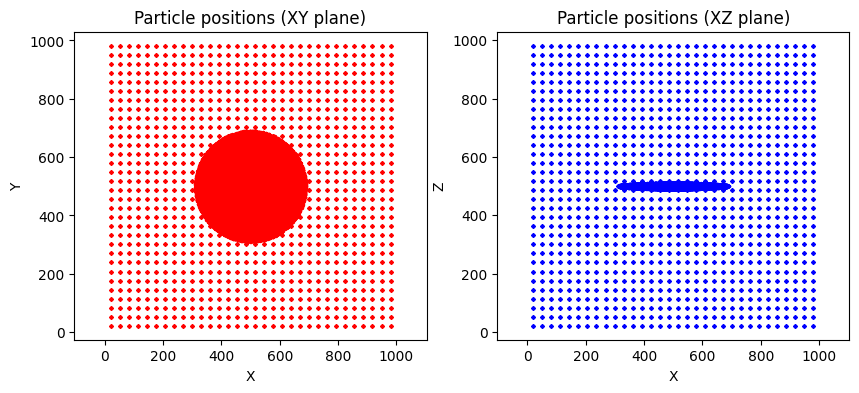


Processing V3...

Check new file header:
BoxSize 1000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1318332  486666 1053333       0       0       0]
NumPart_Total [1318332  486666 1053333       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V3.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V3.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V3/V3.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 3459719.93 Msun. Percentage of galaxy gas mass: 0.4374%
Hacky black hole fi

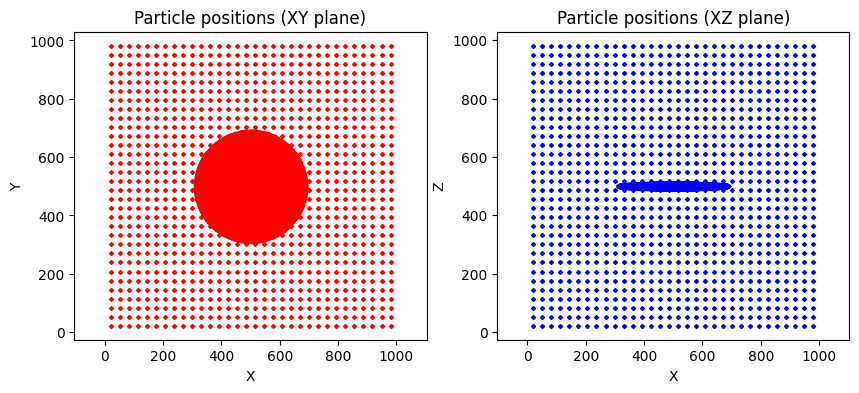


Processing V4...

Check new file header:
BoxSize 1000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1318332  486666 1055333       0       0       0]
NumPart_Total [1318332  486666 1055333       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V4.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V4.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V4/V4.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 3459719.93 Msun. Percentage of galaxy gas mass: 0.4374%
Hacky black hole fi

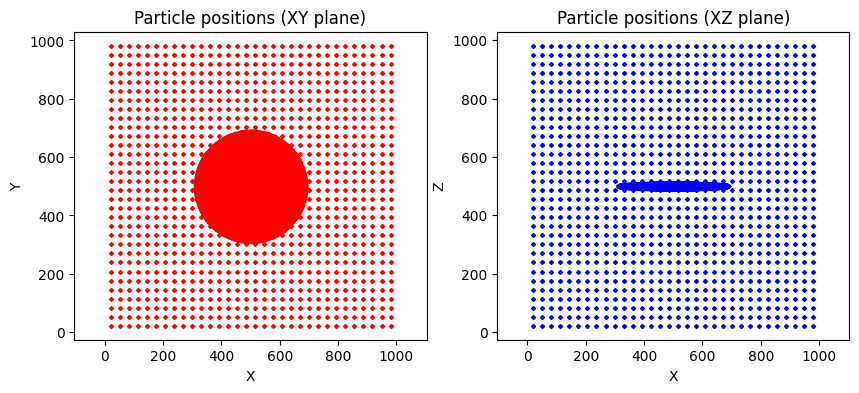


Processing V5...

Check new file header:
BoxSize 1500
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [ 554999  686000 1000000       0       0       0]
NumPart_Total [ 554999  686000 1000000       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V5.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V5.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V5/V5.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 11676554.77 Msun. Percentage of galaxy gas mass: 1.0519%
Hacky black hole f

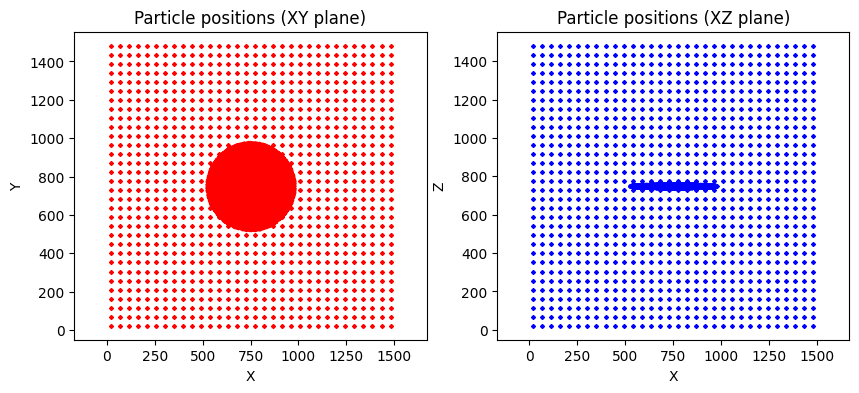


Processing V6...

Check new file header:
BoxSize 1500
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [ 554999  686000 1000000       0       0       0]
NumPart_Total [ 554999  686000 1000000       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V6.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V6.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V6/V6.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 11676554.77 Msun. Percentage of galaxy gas mass: 1.0519%
Hacky black hole f

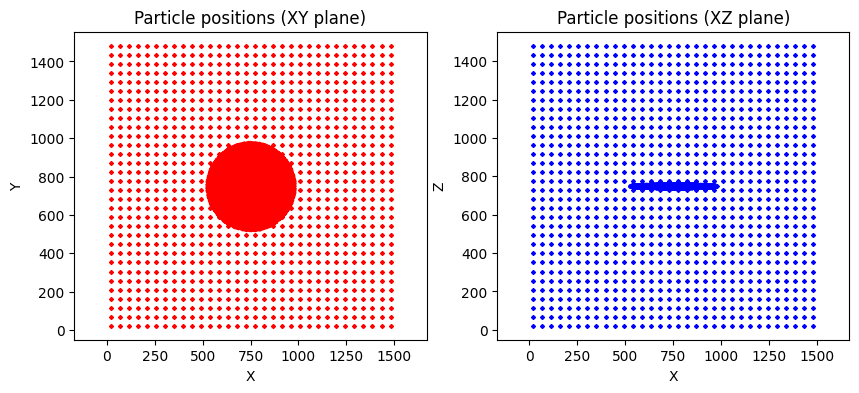


Processing V7...

Check new file header:
BoxSize 1500
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1249999  686000 1000000       0       0       0]
NumPart_Total [1249999  686000 1000000       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V7.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V7.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V7/V7.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 11676554.77 Msun. Percentage of galaxy gas mass: 0.4671%
Hacky black hole f

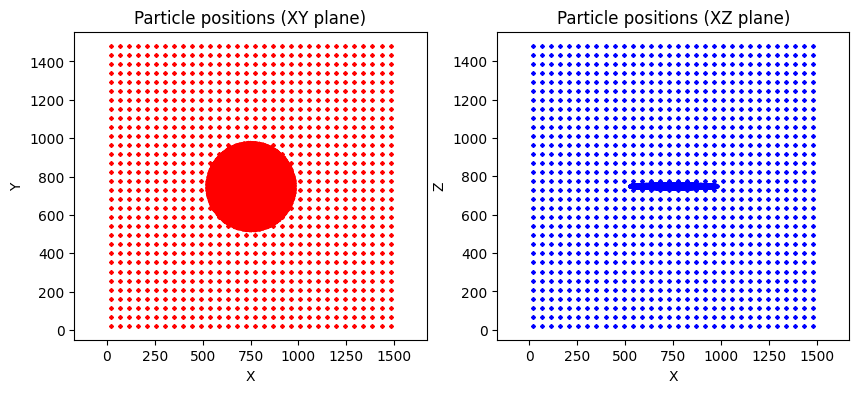


Processing V8...

Check new file header:
BoxSize 1500
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1249999  686000 1000000       0       0       0]
NumPart_Total [1249999  686000 1000000       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V8.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V8.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V8/V8.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 11676554.77 Msun. Percentage of galaxy gas mass: 0.4671%
Hacky black hole f

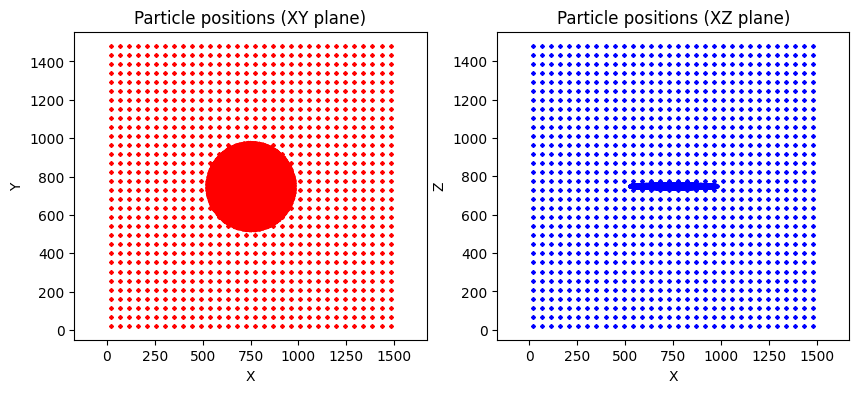


Processing V9...

Check new file header:
BoxSize 2000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1169999  395333 2106666       0       0       0]
NumPart_Total [1169999  395333 2106666       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V9.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V9.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V9/V9.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 27677759.46 Msun. Percentage of galaxy gas mass: 0.7885%
Hacky black hole f

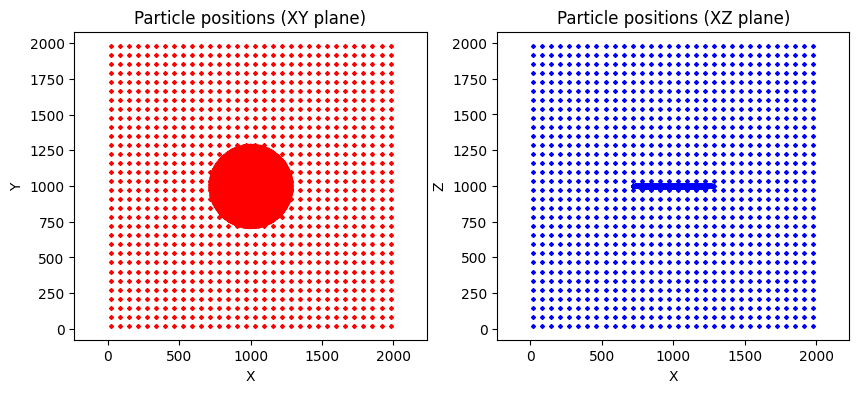


Processing V10...

Check new file header:
BoxSize 2000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1169999  395333 2110666       0       0       0]
NumPart_Total [1169999  395333 2110666       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V10.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V10.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V10/V10.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 27677759.46 Msun. Percentage of galaxy gas mass: 0.7885%
Hacky black h

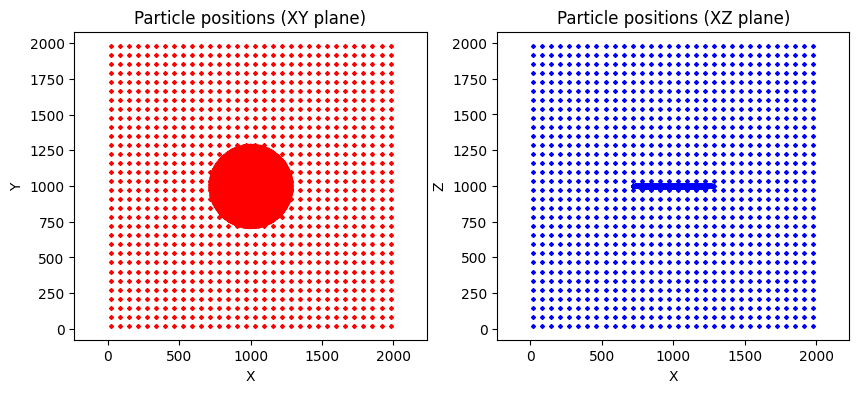


Processing V11...

Check new file header:
BoxSize 2000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1318332  197666 1053333       0       0       0]
NumPart_Total [1318332  197666 1053333       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V11.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V11.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V11/V11.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 27677759.46 Msun. Percentage of galaxy gas mass: 0.3499%
Hacky black h

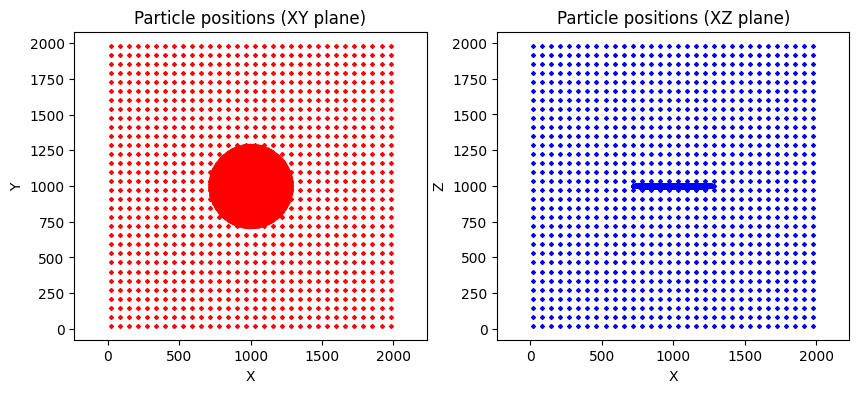


Processing V12...

Check new file header:
BoxSize 2000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1318332  197666 1055333       0       0       0]
NumPart_Total [1318332  197666 1055333       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V12.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V12.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V12/V12.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 27677759.46 Msun. Percentage of galaxy gas mass: 0.3499%
Hacky black h

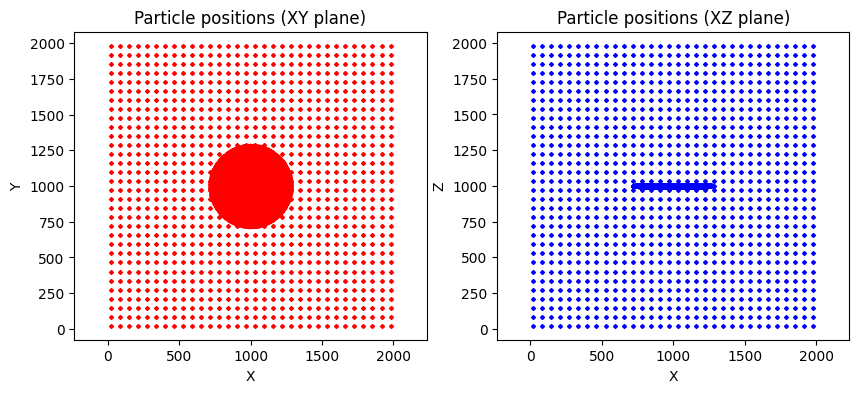


Processing V13...

Check new file header:
BoxSize 2000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1109999  294000 2000000       0       0       0]
NumPart_Total [1109999  294000 2000000       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V13.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V13.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V13/V13.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 27677759.46 Msun. Percentage of galaxy gas mass: 0.2493%
Hacky black h

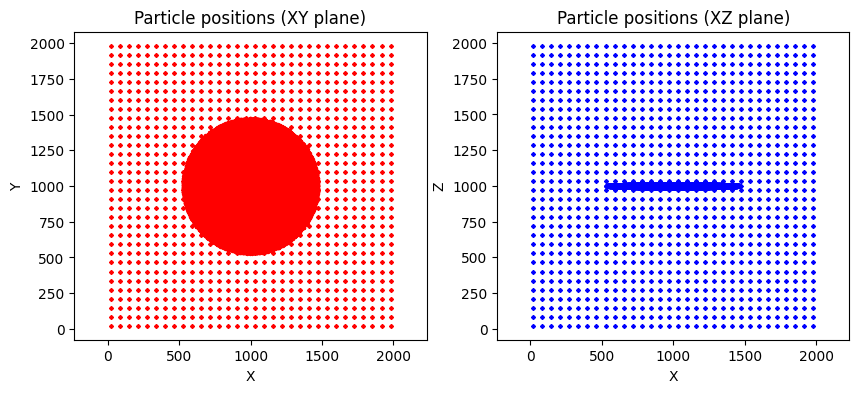


Processing V14...

Check new file header:
BoxSize 2000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1109999  294000 2000000       0       0       0]
NumPart_Total [1109999  294000 2000000       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V14.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V14.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V14/V14.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 27677759.46 Msun. Percentage of galaxy gas mass: 0.2493%
Hacky black h

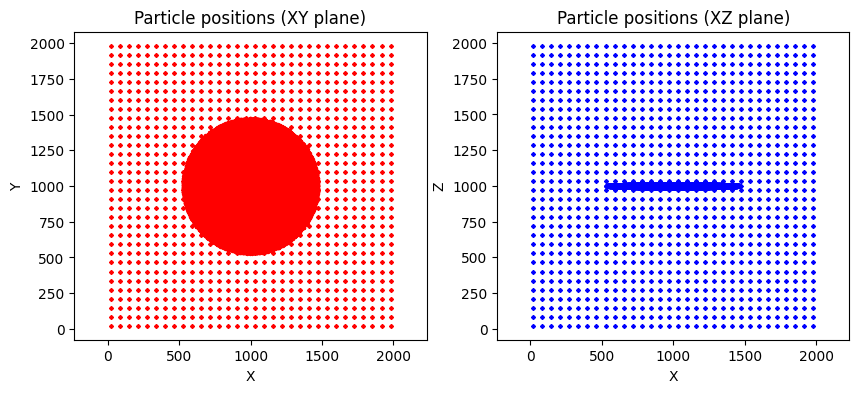


Processing V15...

Check new file header:
BoxSize 2000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1249999  147000 1000000       0       0       0]
NumPart_Total [1249999  147000 1000000       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V15.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V15.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V15/V15.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 27677759.46 Msun. Percentage of galaxy gas mass: 0.1107%
Hacky black h

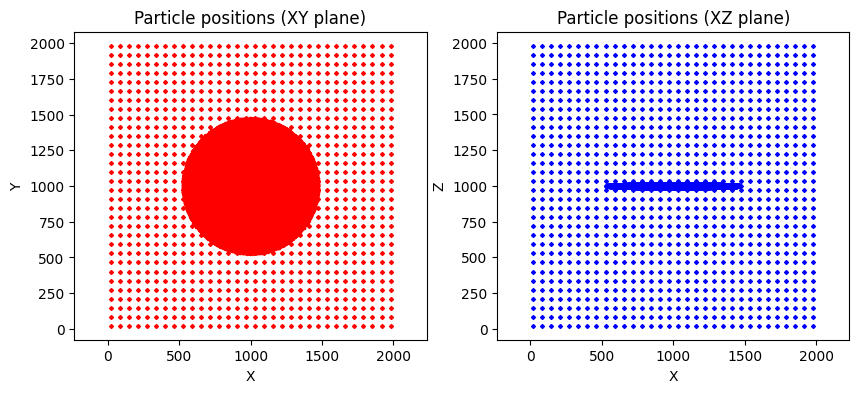


Processing V16...

Check new file header:
BoxSize 2000
HubbleParam 0.0
MassTable [0 0 0 0 0 0]
NumFilesPerSnapshot 1
NumPart_ThisFile [1249999  147000 1000000       0       0       0]
NumPart_Total [1249999  147000 1000000       0       0       0]
NumPart_Total_HighWord [0 0 0 0 0 0]
Omega0 0.0
OmegaLambda 0.0
Redshift 0.0
Time 0.0
UnitLength_in_cm 3.0856e+20
UnitMass_in_g 1.991e+33
UnitVelocity_in_cm_per_s 100000.0

Fixed initial conditions and saved to  /cosma8/data/dp058/dc-faes1/initial_conditions/new_V16.hdf5
Moving /cosma8/data/dp058/dc-faes1/initial_conditions/new_V16.hdf5 -> /cosma8/data/dp058/dc-faes1/arepo2_base/snapshots_V16/V16.hdf5
Shifting coordinates to center on boxsize/2.
Coordinates successfully updated.
Masses successfully updated.
Velocities successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
ParticleIDs successfully updated.
Mass added with background grid: 27677759.46 Msun. Percentage of galaxy gas mass: 0.1107%
Hacky black h

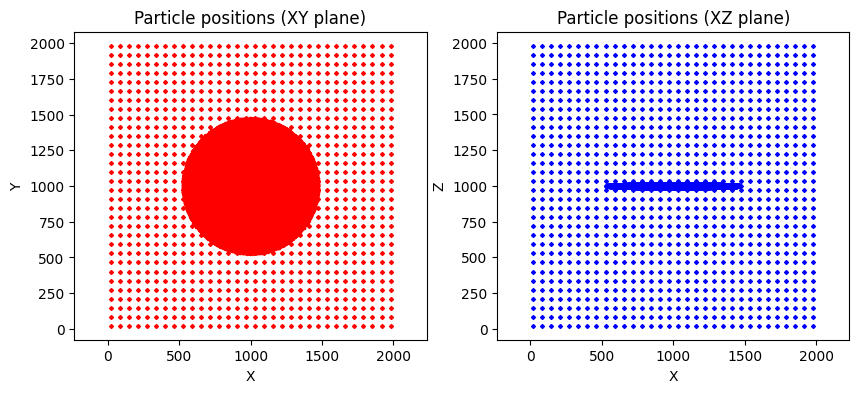

In [3]:
for n in np.arange(1, 17, 1):

    print(f"\nProcessing V{n}...")

    boxsize = boxsizes[(n-1) // 4]
    bh_mass = bh_masses[(n-1) // 4]
    radius = radii[(n-1) // 4]
    height = heights[(n-1) // 4]

    # fix initial condition file format
    fix_ics(os.path.join(ic_path, f"V{n}.hdf5"), boxsize=boxsize, unit_length=3.0856e20, unit_mass=1.991e33, unit_velocity=1.0e5)

    # move ics to run directory
    target_dir = os.path.join(run_path, f"snapshots_V{n}")
    src = os.path.join(ic_path, f"new_V{n}.hdf5")
    dst = os.path.join(target_dir, f"V{n}.hdf5")

    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    if os.path.exists(src):
        try:
            print(f"Moving {src} -> {dst}")
            shutil.move(src, dst)
        except Exception as e:
            print(f"Error moving {src} -> {dst}: {e}")
    else:
        print(f"Source file not found, skipping: {src}")

    add_background_grid(dst, disk_radius_in_kpc=radius, disk_height_in_kpc=height, ndensity_per_cm3=1e-7, grid_size=32, boxsize=boxsize, margin=20)

    add_bh_particle(dst, bh_mass)

    f = h5py.File(dst, 'r')
    coords = np.array(f['PartType0']['Coordinates'])
    f.close()

    # Plot XY and XZ planes
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(coords[:, 0], coords[:, 1], s=2, color="red")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Particle positions (XY plane)")
    plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(coords[:, 0], coords[:, 2], s=2, color="blue")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.title(f"Particle positions (XZ plane)")
    plt.axis("equal")
    plt.show()


# Run AREPO to get snapshot 000, then


Processing V1_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 1000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [ 617767  486666 1053333       0       0       0]
NumPart_Total [ 617767  486666 1053333       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  617767
Gas particle coordinate ranges:
x:  20.0 980.0
y:  22.0 982.0
z:  21.0 981.0


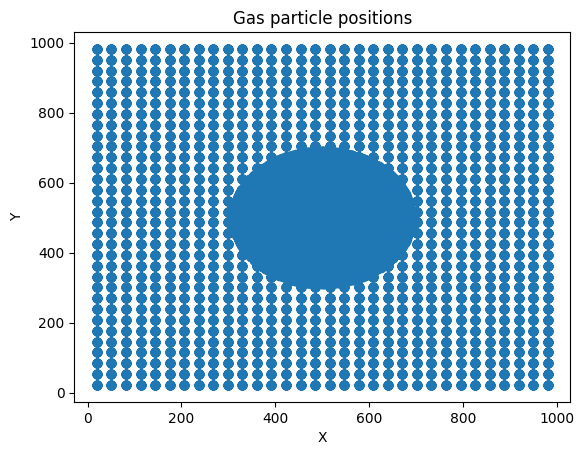

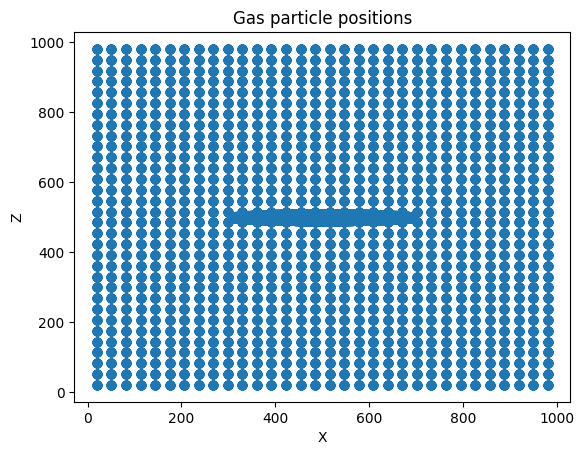


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 299610.6875
BH particle mass: 615610.125

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 617759 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  354455995.7352646
mean disk_density (g cm-3):  1.7778965e-25
mean disk_ndensity (cm-3):  0.07592429
mean disk_temp (K):  10342.3545

 Check disk properties...
Disk mask: 584991 particles in disk with radii [ 0 20] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  350996117.56185883
mean disk_density (g cm-3):  1.8774843e-25
mean disk_ndensity (cm-3):  0.08017713
mean disk_temp (K):  10342.354

 Check CGM properties...
Temperature mask: 617767 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 20 100] kp

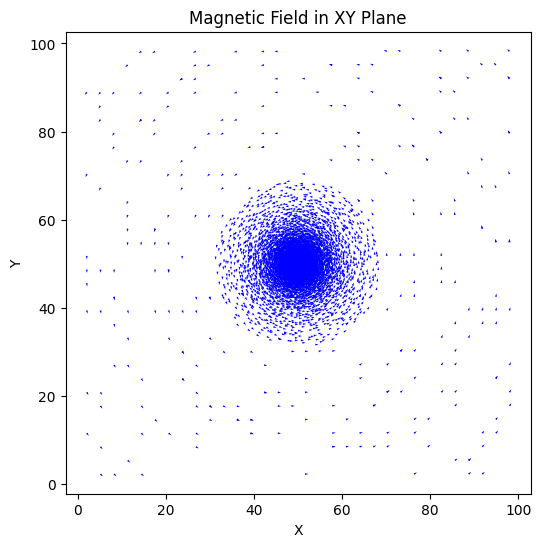

Average magnetic field magnitude: 1.0000002128446317e-12 G


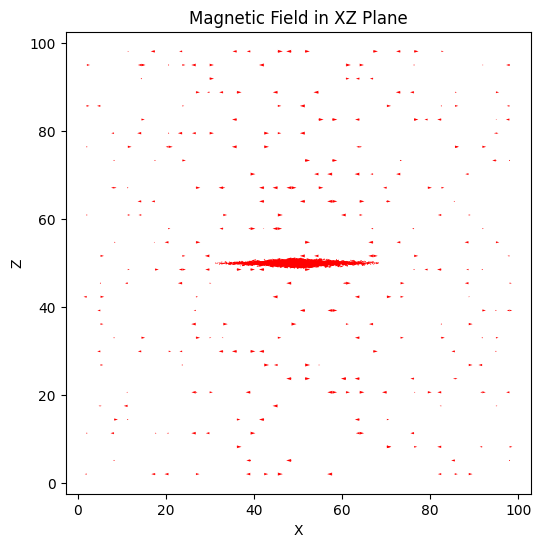


Processing V2_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 1000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [ 617767  486666 1055333       0       0       0]
NumPart_Total [ 617767  486666 1055333       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  617767
Gas particle coordinate ranges:
x:  20.0 980.0
y:  22.0 982.0
z:  21.0 981.0


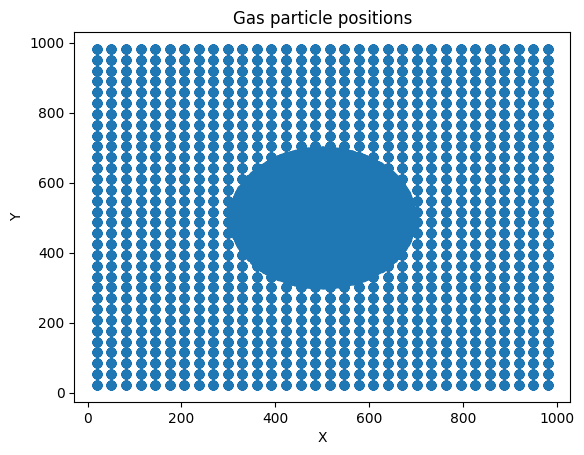

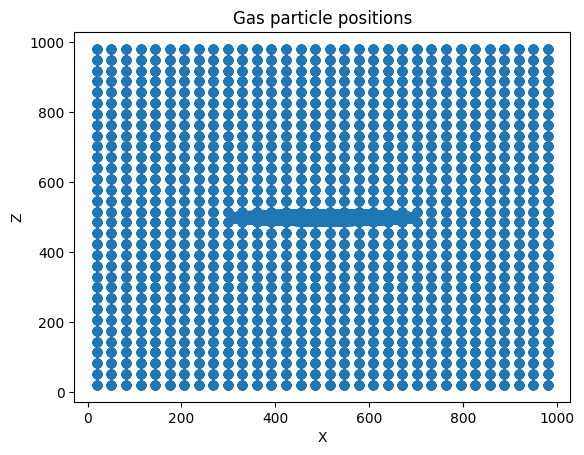


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 299610.6875
BH particle mass: 615610.125

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 617759 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  354456059.81895
mean disk_density (g cm-3):  1.7778965e-25
mean disk_ndensity (cm-3):  0.07592427
mean disk_temp (K):  62837.11

 Check disk properties...
Disk mask: 584991 particles in disk with radii [ 0 20] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  350996117.56185883
mean disk_density (g cm-3):  1.8774845e-25
mean disk_ndensity (cm-3):  0.08017713
mean disk_temp (K):  10342.354

 Check CGM properties...
Temperature mask: 617767 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 20 100] kpc an

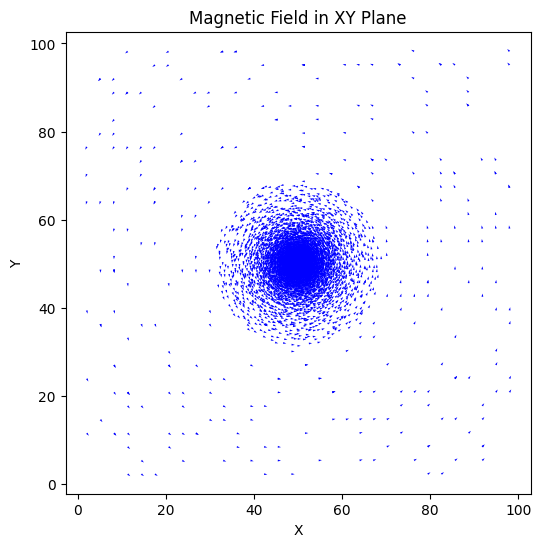

Average magnetic field magnitude: 1.0000002128446317e-12 G


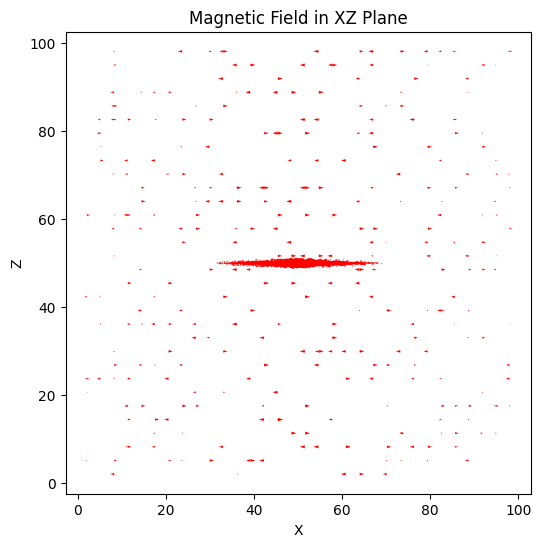


Processing V3_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 1000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1351100  486666 1053333       0       0       0]
NumPart_Total [1351100  486666 1053333       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1351100
Gas particle coordinate ranges:
x:  20.0 980.0
y:  22.0 982.0
z:  21.0 981.0


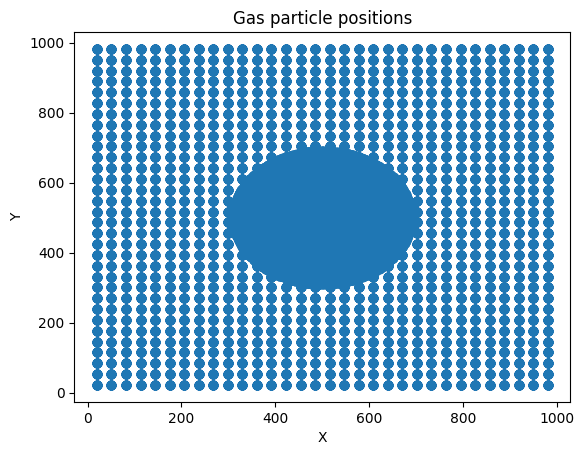

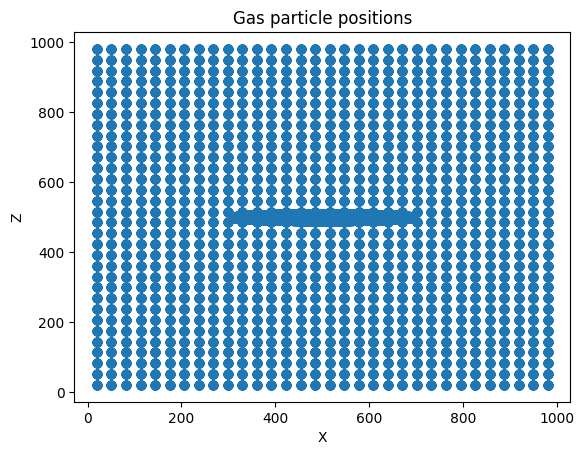


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 299610.6875
BH particle mass: 615610.125

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1351084 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  794453201.7219876
mean disk_density (g cm-3):  4.1690116e-25
mean disk_ndensity (cm-3):  0.17803577
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1318316 particles in disk with radii [ 0 20] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  790992874.9627843
mean disk_density (g cm-3):  4.2726363e-25
mean disk_ndensity (cm-3):  0.18246098
mean disk_temp (K):  10342.365

 Check CGM properties...
Temperature mask: 1351100 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 20 100] k

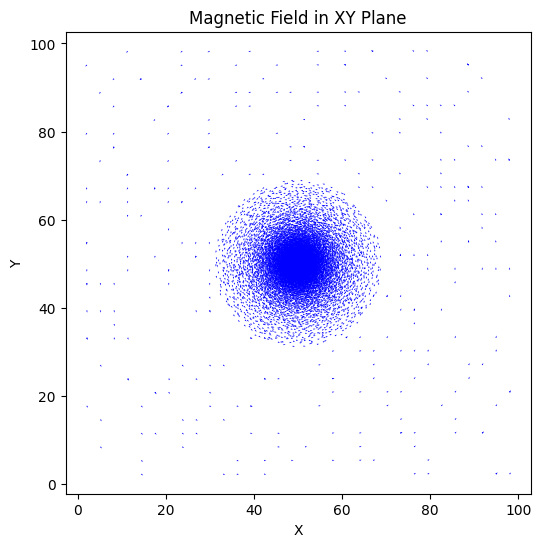

Average magnetic field magnitude: 1.0000001044244144e-12 G


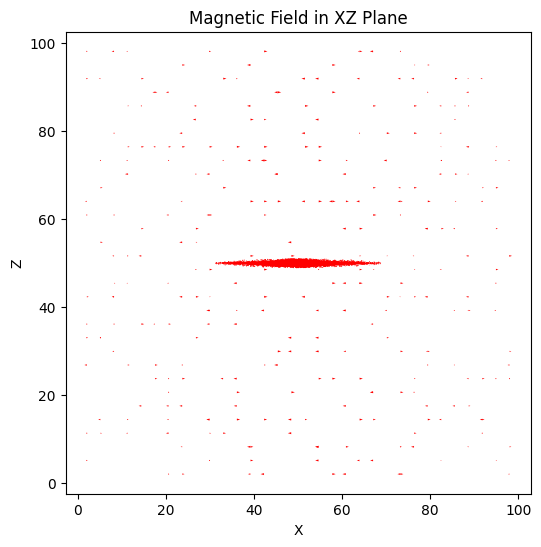


Processing V4_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 1000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1351100  486666 1055333       0       0       0]
NumPart_Total [1351100  486666 1055333       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1351100
Gas particle coordinate ranges:
x:  20.0 980.0
y:  22.0 982.0
z:  21.0 981.0


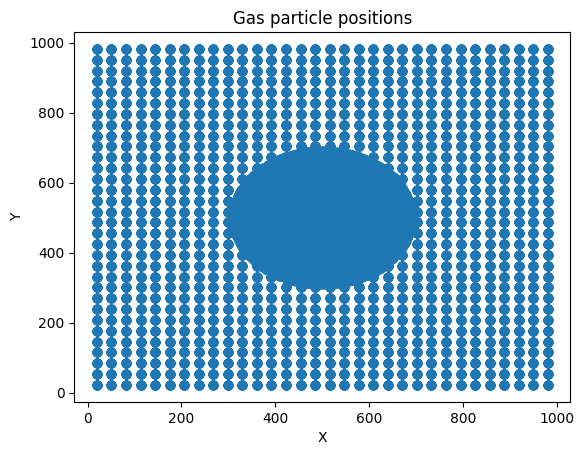

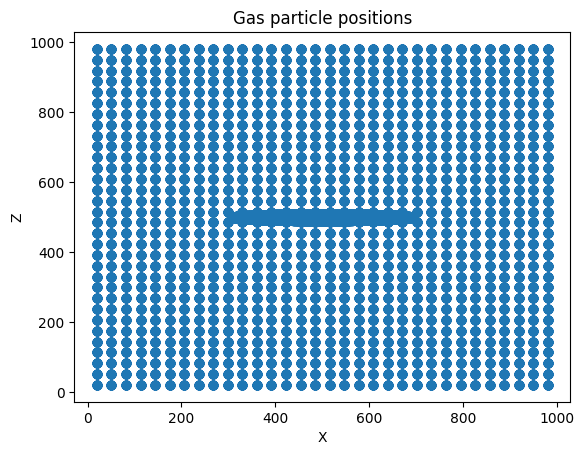


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 299610.6875
BH particle mass: 615610.125

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1351084 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  794453265.805673
mean disk_density (g cm-3):  4.1690106e-25
mean disk_ndensity (cm-3):  0.17803577
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1318316 particles in disk with radii [ 0 20] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  790992874.9627843
mean disk_density (g cm-3):  4.272637e-25
mean disk_ndensity (cm-3):  0.18246101
mean disk_temp (K):  10342.365

 Check CGM properties...
Temperature mask: 1351100 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 20 100] kpc

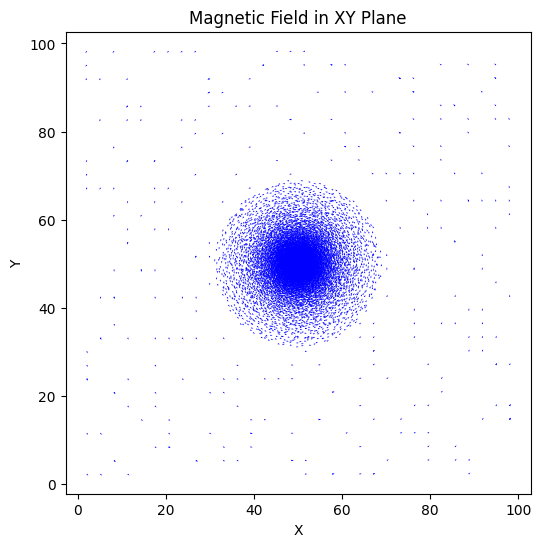

Average magnetic field magnitude: 1.0000001044244144e-12 G


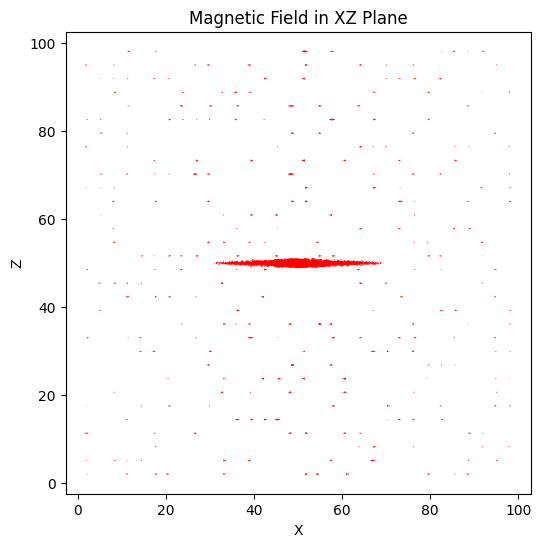


Processing V5_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 1500.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [ 587767  686000 1000000       0       0       0]
NumPart_Total [ 587767  686000 1000000       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  587767
Gas particle coordinate ranges:
x:  20.0 1480.0
y:  22.0 1482.0
z:  21.0 1481.0


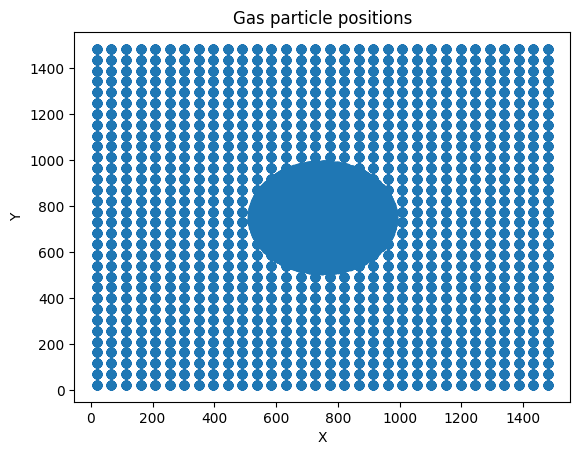

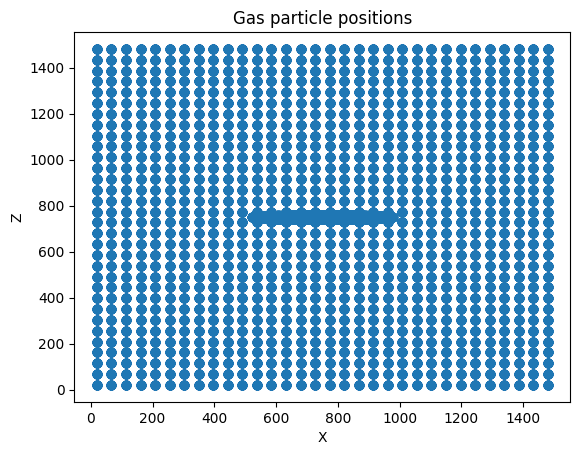


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 998700.5
BH particle mass: 1998699.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 587756 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  1121658283.130155
mean disk_density (g cm-3):  5.157265e-25
mean disk_ndensity (cm-3):  0.22023876
mean disk_temp (K):  10342.354

 Check disk properties...
Disk mask: 554988 particles in disk with radii [ 0 25] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  1109981466.6505735
mean disk_density (g cm-3):  5.4617653e-25
mean disk_ndensity (cm-3):  0.23324218
mean disk_temp (K):  10342.353

 Check CGM properties...
Temperature mask: 587767 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 25 100] kpc and 

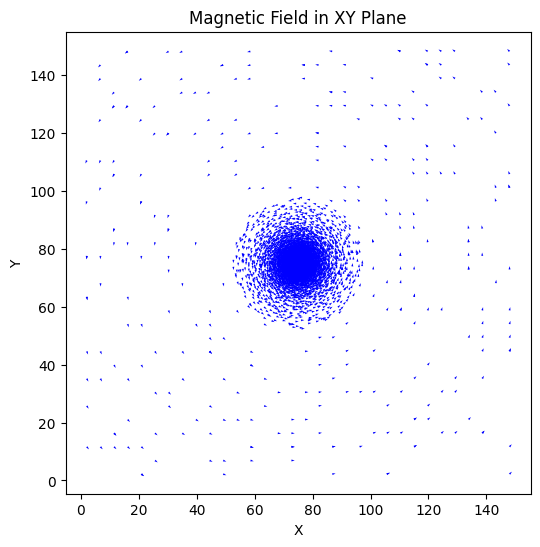

Average magnetic field magnitude: 1.0000001044244144e-12 G


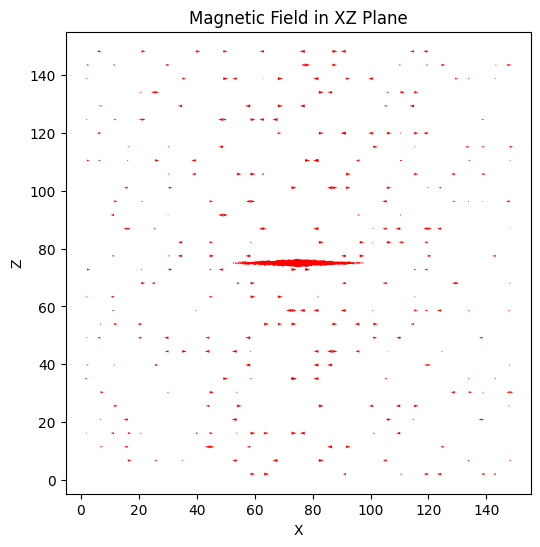


Processing V6_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 1500.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [ 587767  686000 1000000       0       0       0]
NumPart_Total [ 587767  686000 1000000       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  587767
Gas particle coordinate ranges:
x:  20.0 1480.0
y:  22.0 1482.0
z:  21.0 1481.0


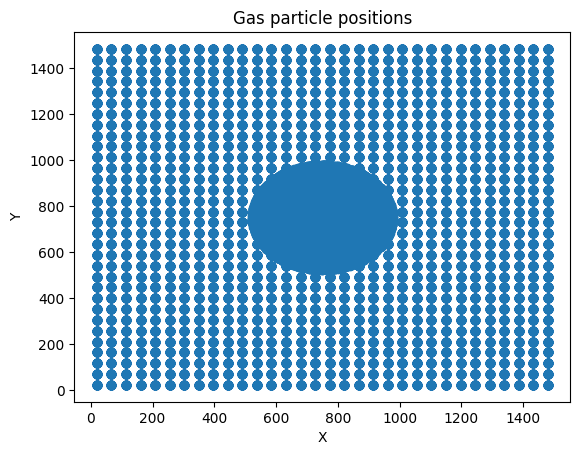

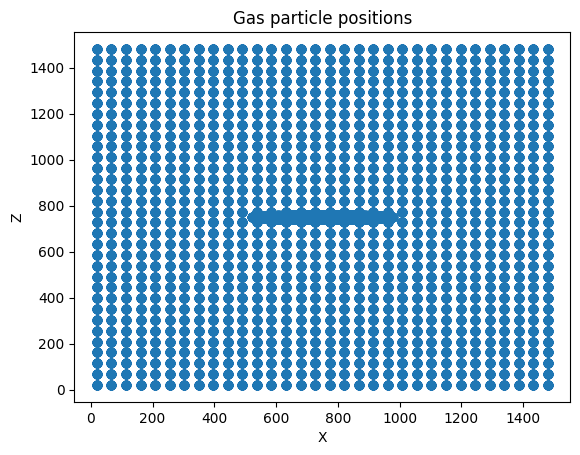


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 998700.5
BH particle mass: 1998699.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 587756 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  1121658283.130155
mean disk_density (g cm-3):  5.1572644e-25
mean disk_ndensity (cm-3):  0.22023875
mean disk_temp (K):  10342.354

 Check disk properties...
Disk mask: 554988 particles in disk with radii [ 0 25] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  1109981466.6505735
mean disk_density (g cm-3):  5.461765e-25
mean disk_ndensity (cm-3):  0.23324223
mean disk_temp (K):  10342.353

 Check CGM properties...
Temperature mask: 587767 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 25 100] kpc and 

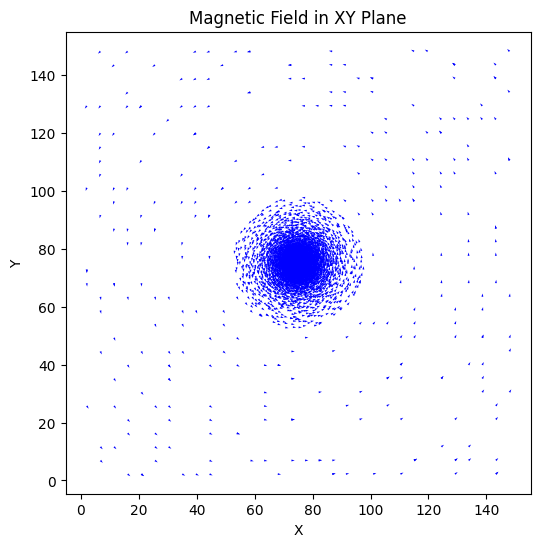

Average magnetic field magnitude: 1.0000001044244144e-12 G


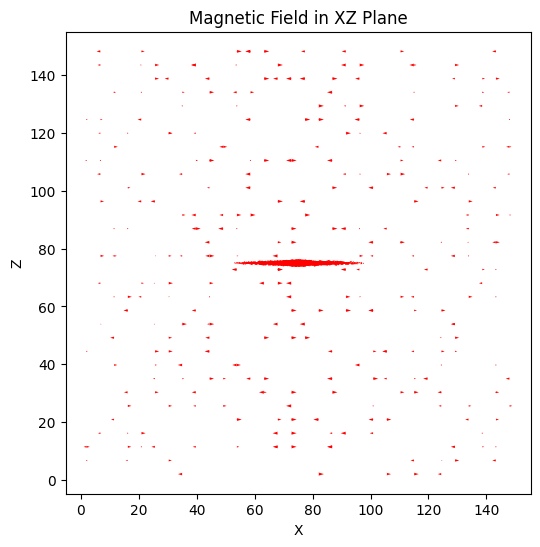


Processing V7_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 1500.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1282767  686000 1000000       0       0       0]
NumPart_Total [1282767  686000 1000000       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1282767
Gas particle coordinate ranges:
x:  20.0 1480.0
y:  22.0 1482.0
z:  21.0 1481.0


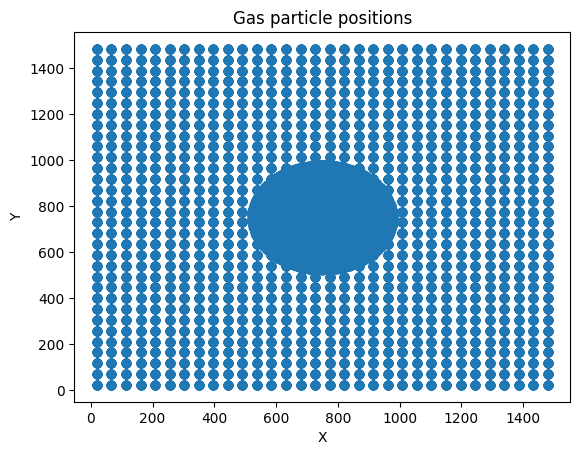

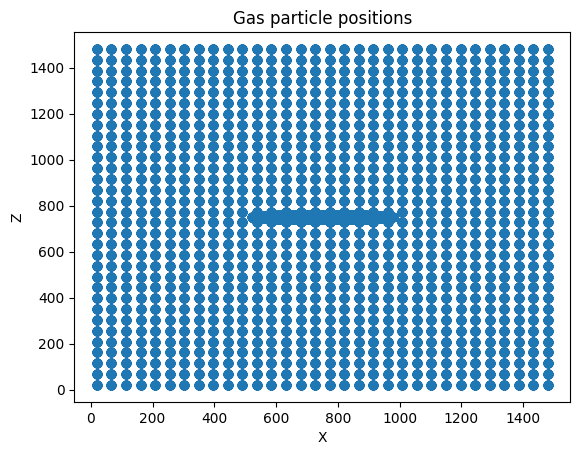


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 998700.5
BH particle mass: 1998699.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1282741 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  2511633675.252465
mean disk_density (g cm-3):  1.2135394e-24
mean disk_ndensity (cm-3):  0.5182366
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1249973 particles in disk with radii [ 0 25] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  2499955577.0991755
mean disk_density (g cm-3):  1.2453522e-24
mean disk_ndensity (cm-3):  0.5318221
mean disk_temp (K):  10342.365

 Check CGM properties...
Temperature mask: 1282767 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 25 100] kpc an

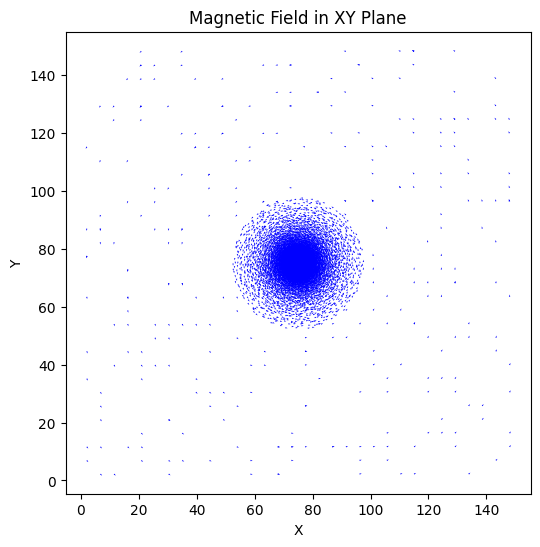

Average magnetic field magnitude: 1.0000001044244144e-12 G


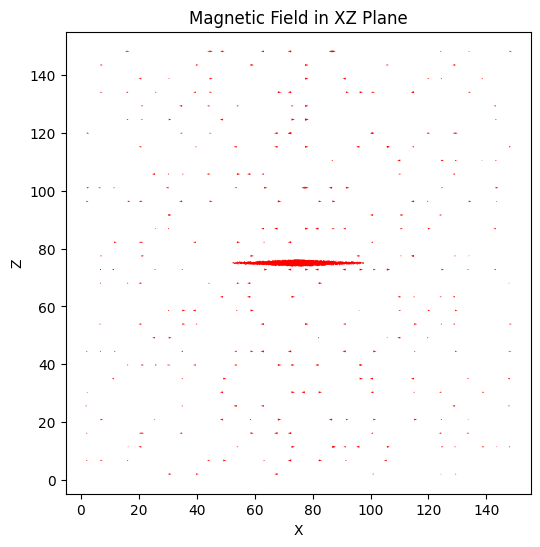


Processing V8_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 1500.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1282767  686000 1000000       0       0       0]
NumPart_Total [1282767  686000 1000000       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1282767
Gas particle coordinate ranges:
x:  20.0 1480.0
y:  22.0 1482.0
z:  21.0 1481.0


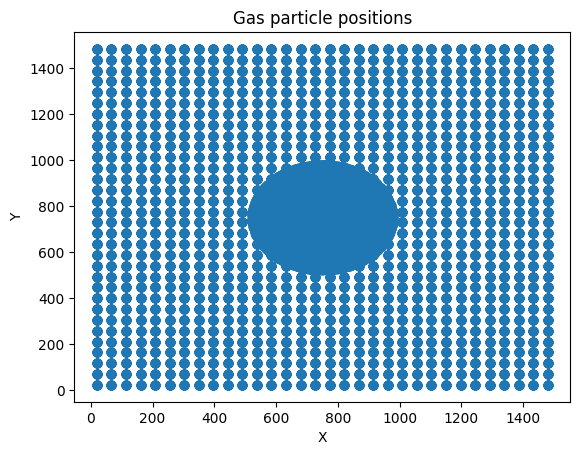

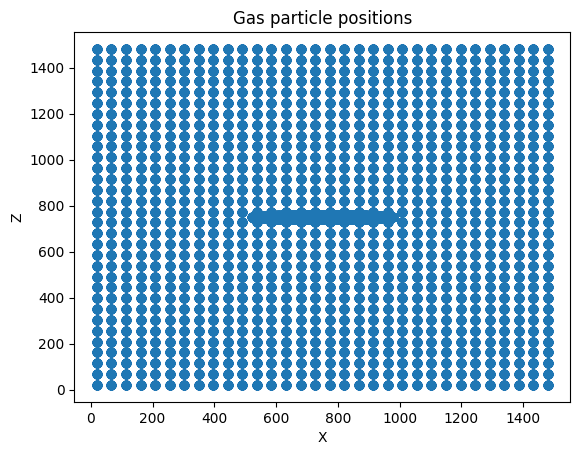


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 998700.5
BH particle mass: 1998699.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1282741 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  2511633675.252465
mean disk_density (g cm-3):  1.2135392e-24
mean disk_ndensity (cm-3):  0.5182366
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1249973 particles in disk with radii [ 0 25] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  2499955577.0991755
mean disk_density (g cm-3):  1.2453519e-24
mean disk_ndensity (cm-3):  0.531822
mean disk_temp (K):  10342.365

 Check CGM properties...
Temperature mask: 1282767 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 25 100] kpc and

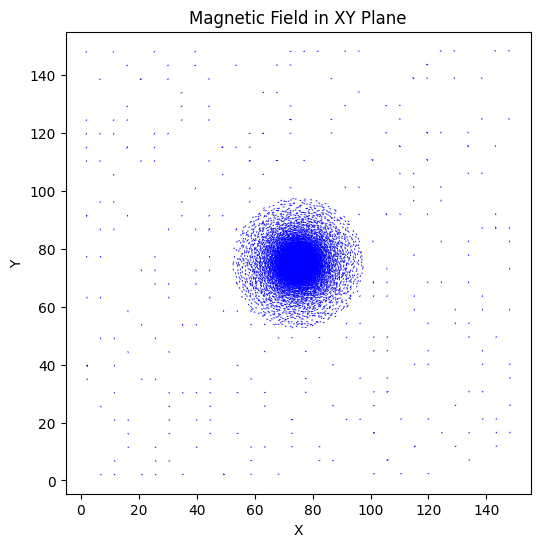

Average magnetic field magnitude: 1.0000001044244144e-12 G


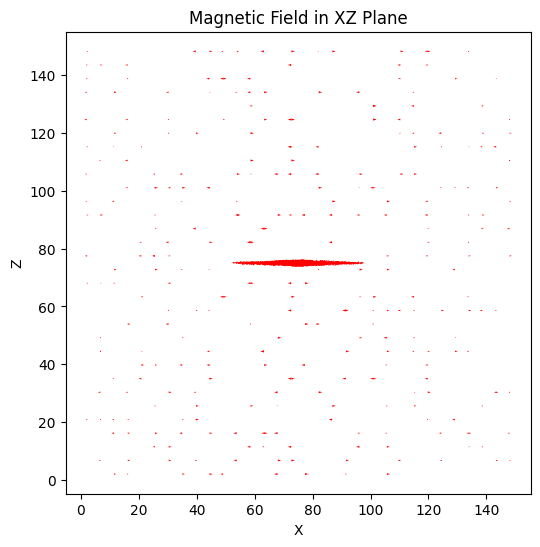


Processing V9_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 2000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1202767  395333 2106666       0       0       0]
NumPart_Total [1202767  395333 2106666       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1202767
Gas particle coordinate ranges:
x:  20.0 1980.0
y:  22.0 1982.0
z:  21.0 1981.0


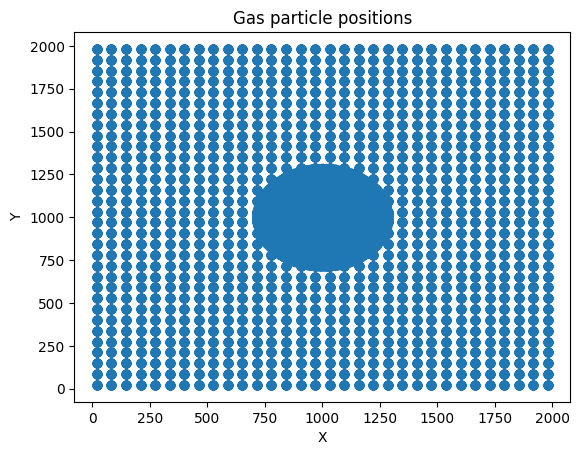

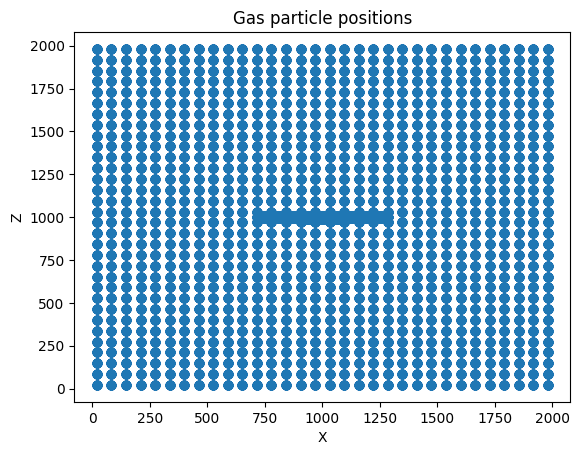


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 1498056.875
BH particle mass: 4658050.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1202753 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  3537650133.9770675
mean disk_density (g cm-3):  5.9480886e-25
mean disk_ndensity (cm-3):  0.25401044
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1169985 particles in disk with radii [ 0 30] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  3509969057.9118896
mean disk_density (g cm-3):  6.1146763e-25
mean disk_ndensity (cm-3):  0.2611246
mean disk_temp (K):  10342.364

 Check CGM properties...
Temperature mask: 1202767 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 30 100] k

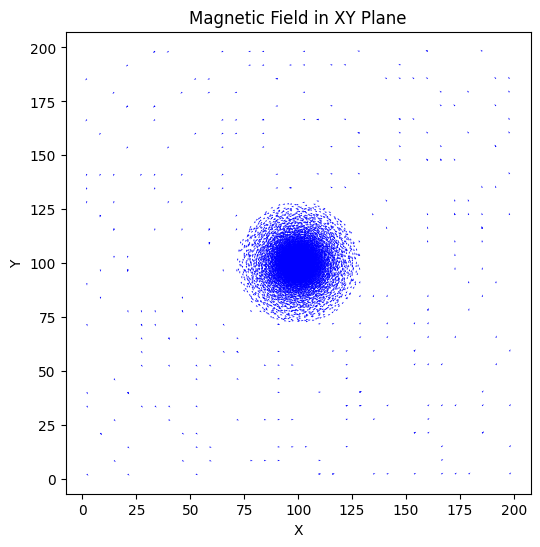

Average magnetic field magnitude: 1.0000001044244144e-12 G


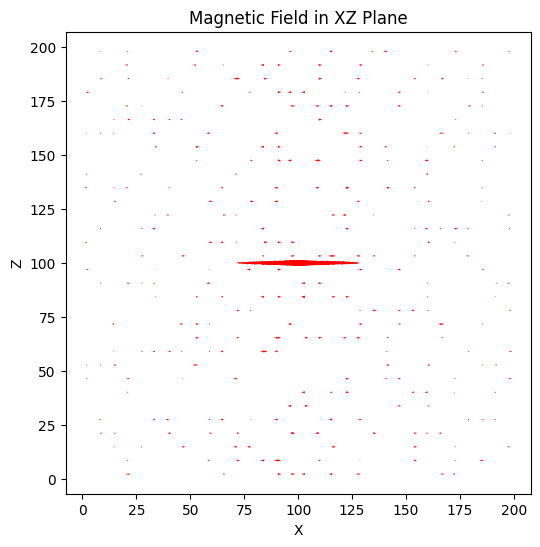


Processing V10_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 2000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1202767  395333 2110666       0       0       0]
NumPart_Total [1202767  395333 2110666       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1202767
Gas particle coordinate ranges:
x:  20.0 1980.0
y:  22.0 1982.0
z:  21.0 1981.0


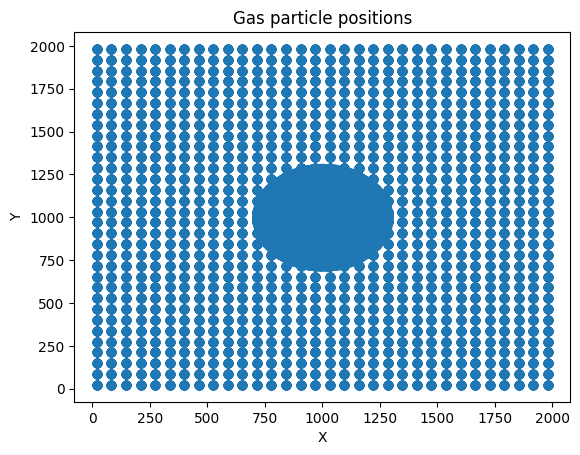

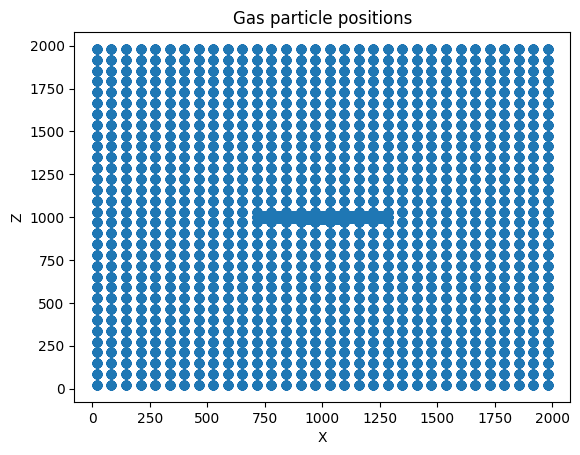


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 1498056.875
BH particle mass: 4658050.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1202753 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  3537649621.307585
mean disk_density (g cm-3):  5.9480867e-25
mean disk_ndensity (cm-3):  0.25401047
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1169985 particles in disk with radii [ 0 30] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  3509969057.9118896
mean disk_density (g cm-3):  6.1146793e-25
mean disk_ndensity (cm-3):  0.26112464
mean disk_temp (K):  10342.364

 Check CGM properties...
Temperature mask: 1202767 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 30 100] k

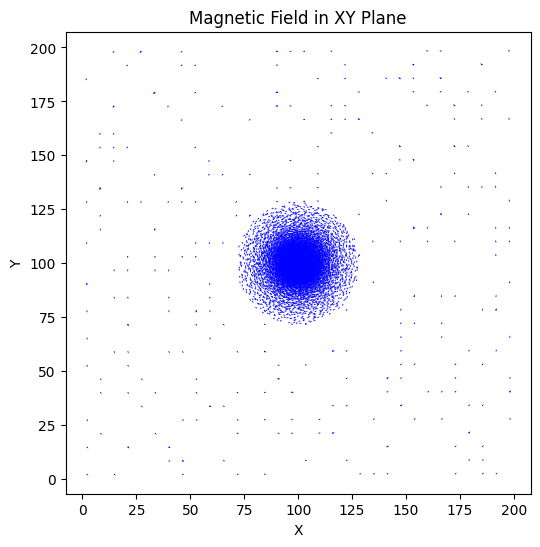

Average magnetic field magnitude: 1.0000001044244144e-12 G


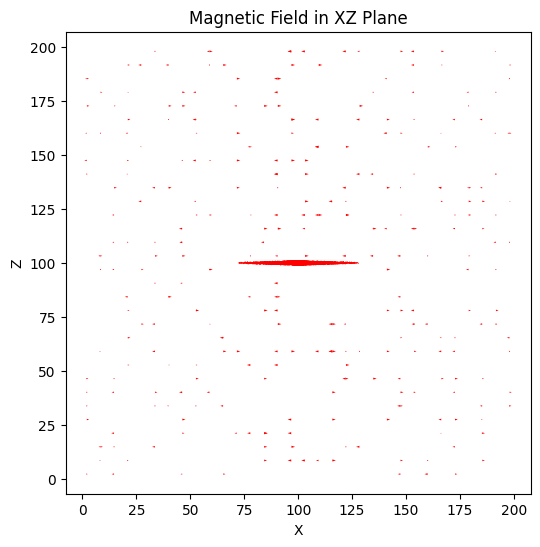


Processing V11_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 2000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1351100  197666 1053333       0       0       0]
NumPart_Total [1351100  197666 1053333       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1351100
Gas particle coordinate ranges:
x:  20.0 1980.0
y:  22.0 1982.0
z:  21.0 1981.0


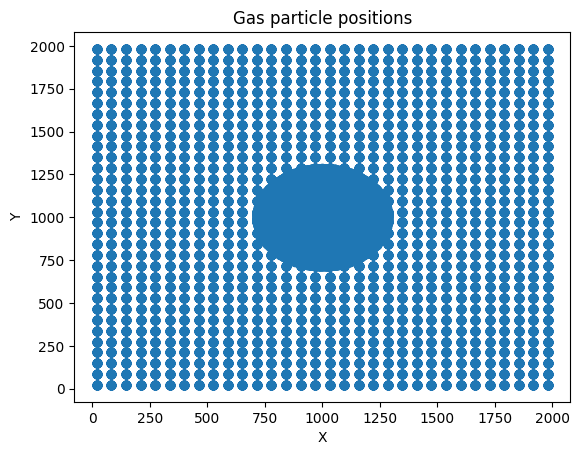

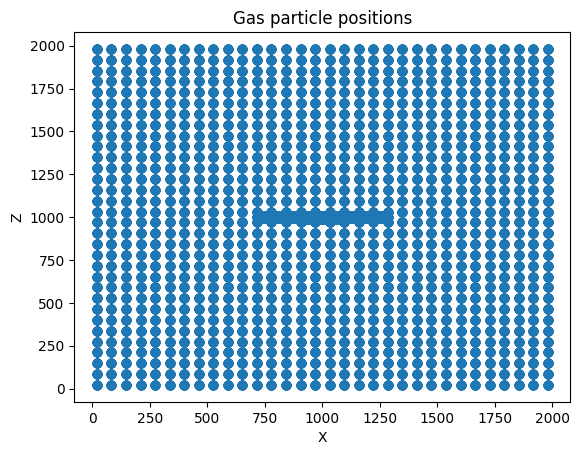


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 2996123.75
BH particle mass: 6156107.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1351084 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  7937612901.709919
mean disk_density (g cm-3):  1.3459348e-24
mean disk_ndensity (cm-3):  0.5747753
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1318316 particles in disk with radii [ 0 30] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  7909930800.305775
mean disk_density (g cm-3):  1.3793887e-24
mean disk_ndensity (cm-3):  0.58906186
mean disk_temp (K):  10342.365

 Check CGM properties...
Temperature mask: 1351100 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 30 100] kpc 

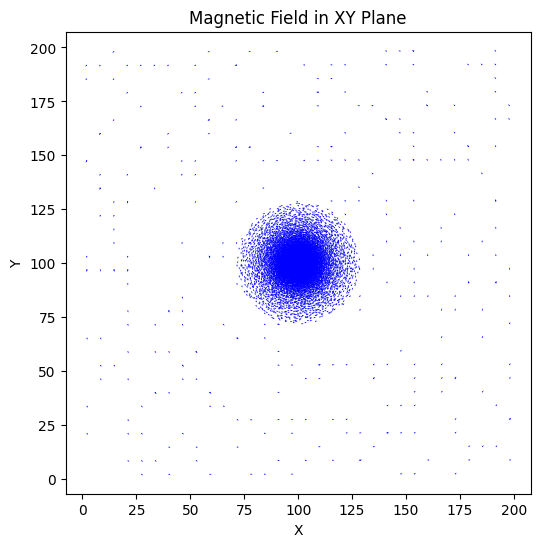

Average magnetic field magnitude: 1.0000001044244144e-12 G


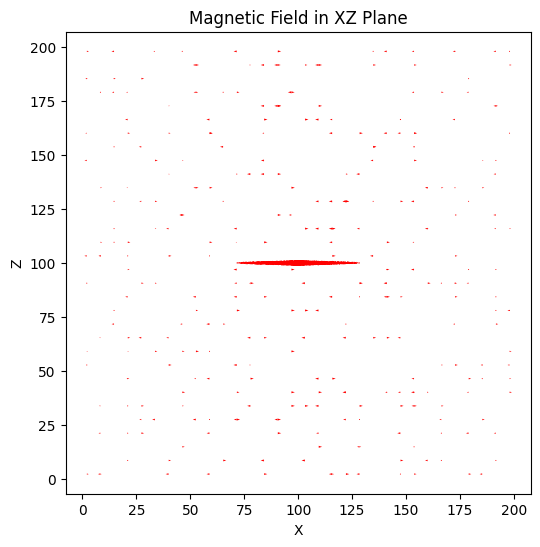


Processing V12_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 2000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1351100  197666 1055333       0       0       0]
NumPart_Total [1351100  197666 1055333       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1351100
Gas particle coordinate ranges:
x:  20.0 1980.0
y:  22.0 1982.0
z:  21.0 1981.0


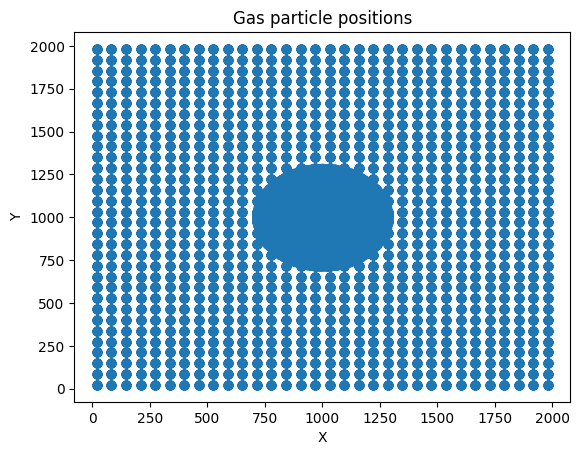

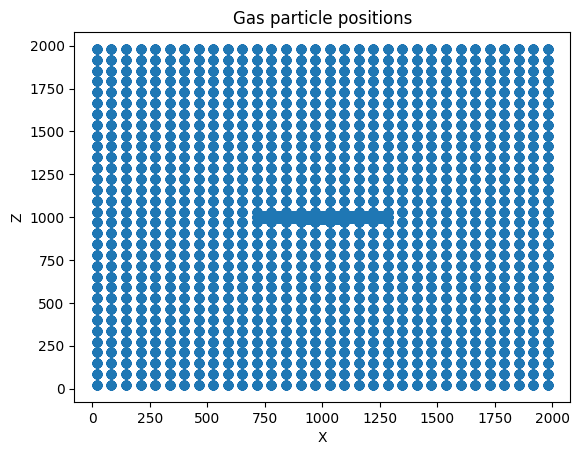


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 2996123.75
BH particle mass: 6156107.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1351084 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  7937612389.040436
mean disk_density (g cm-3):  1.3459344e-24
mean disk_ndensity (cm-3):  0.57477516
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1318316 particles in disk with radii [ 0 30] kpc and half heights [0. 1.] kpc
Total disk mass (M_sun):  7909930800.305775
mean disk_density (g cm-3):  1.3793888e-24
mean disk_ndensity (cm-3):  0.58906156
mean disk_temp (K):  10342.365

 Check CGM properties...
Temperature mask: 1351100 particles in region with temperature above 1 K
CGM mask: 32768 particles in region with radii [ 30 100] kpc

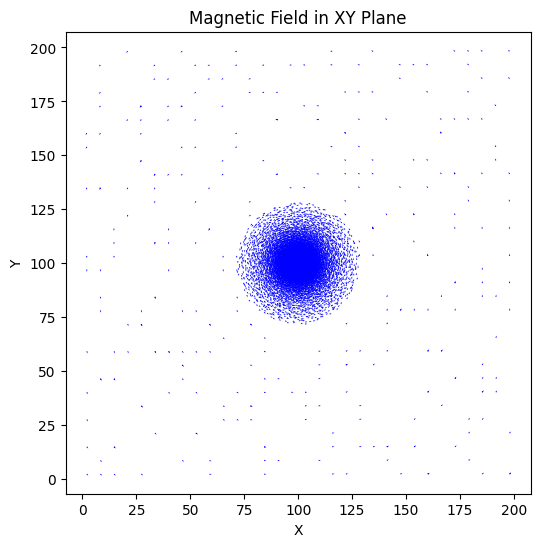

Average magnetic field magnitude: 1.0000001044244144e-12 G


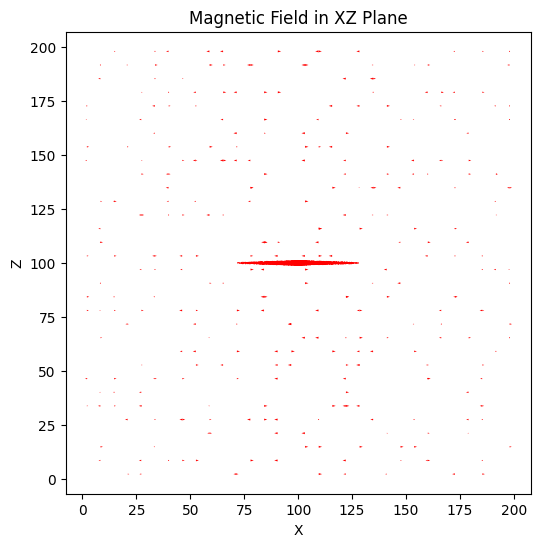


Processing V13_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 2000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1142767  294000 2000000       0       0       0]
NumPart_Total [1142767  294000 2000000       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1142767
Gas particle coordinate ranges:
x:  20.0 1980.0
y:  22.0 1982.0
z:  21.0 1981.0


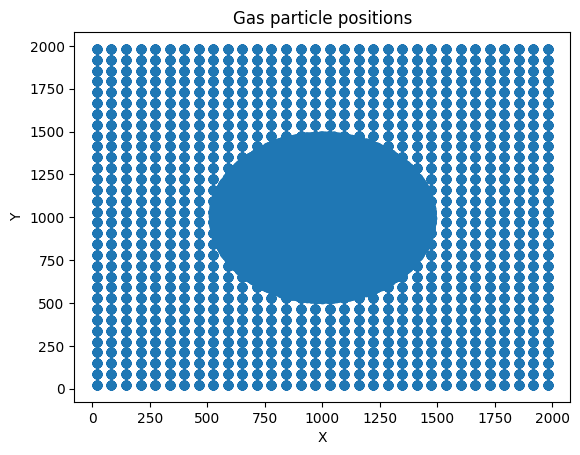

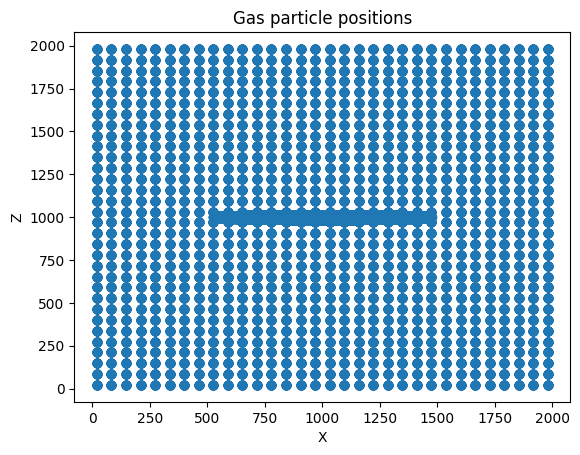


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 4993528.0
BH particle mass: 14993496.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1142758 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  11127630574.644943
mean disk_density (g cm-3):  4.058265e-25
mean disk_ndensity (cm-3):  0.17330639
mean disk_temp (K):  10342.364

 Check disk properties...
Disk mask: 1072949 particles in disk with radii [ 0 40] kpc and half heights [0.  1.5] kpc
Total disk mass (M_sun):  10729549898.467112
mean disk_density (g cm-3):  4.318317e-25
mean disk_ndensity (cm-3):  0.18441172
mean disk_temp (K):  10342.364

 Check CGM properties...
Temperature mask: 1142767 particles in region with temperature above 1 K
CGM mask: 69809 particles in region with radii [ 40 100] k

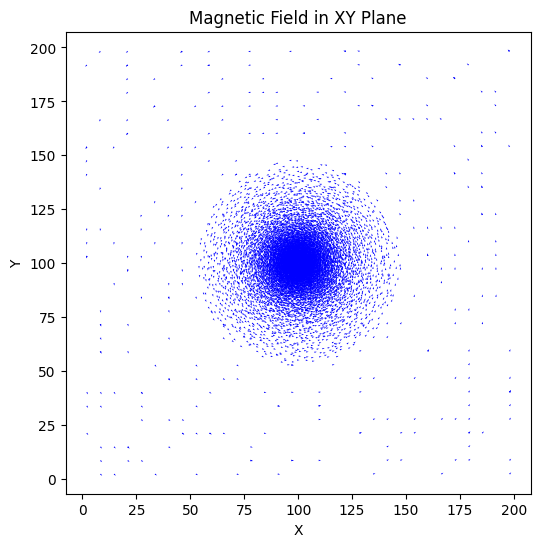

Average magnetic field magnitude: 1.0000001044244144e-12 G


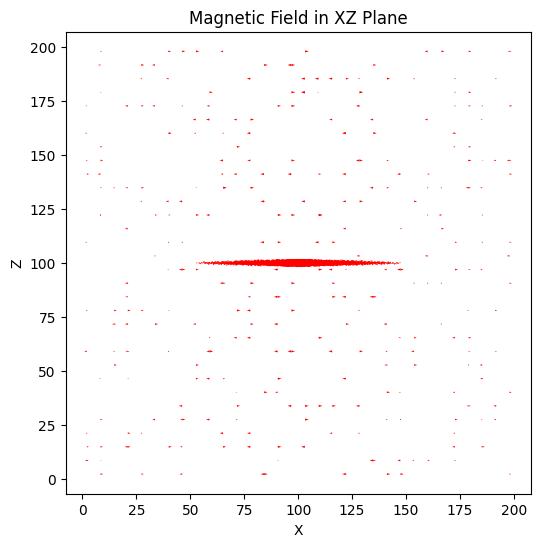


Processing V14_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 2000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1142767  294000 2000000       0       0       0]
NumPart_Total [1142767  294000 2000000       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1142767
Gas particle coordinate ranges:
x:  20.0 1980.0
y:  22.0 1982.0
z:  21.0 1981.0


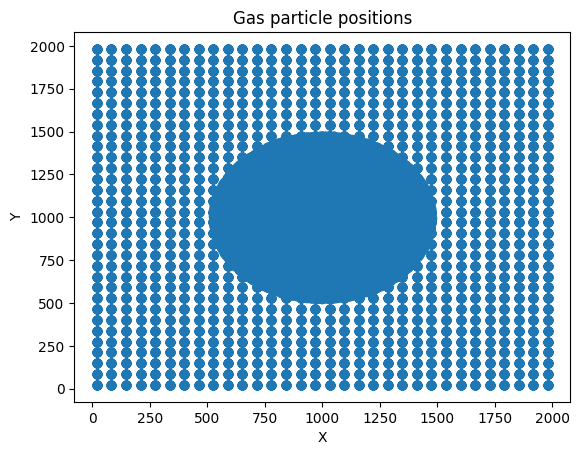

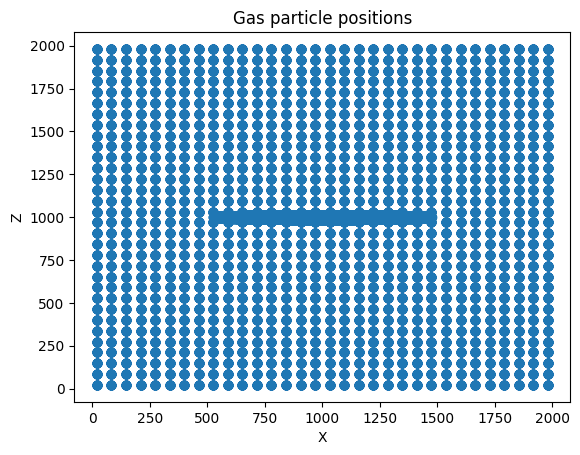


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 4993528.5
BH particle mass: 14993496.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1142758 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  11127634676.000807
mean disk_density (g cm-3):  4.0582644e-25
mean disk_ndensity (cm-3):  0.17330638
mean disk_temp (K):  10342.364

 Check disk properties...
Disk mask: 1072949 particles in disk with radii [ 0 40] kpc and half heights [0.  1.5] kpc
Total disk mass (M_sun):  10729549898.467112
mean disk_density (g cm-3):  4.3183183e-25
mean disk_ndensity (cm-3):  0.1844118
mean disk_temp (K):  10342.364

 Check CGM properties...
Temperature mask: 1142767 particles in region with temperature above 1 K
CGM mask: 69809 particles in region with radii [ 40 100] 

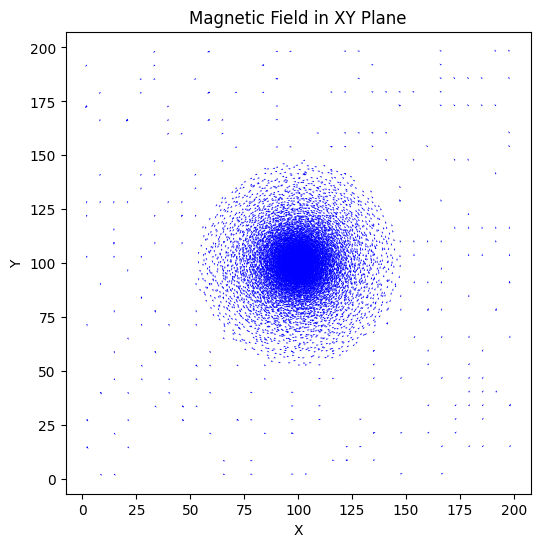

Average magnetic field magnitude: 1.0000001044244144e-12 G


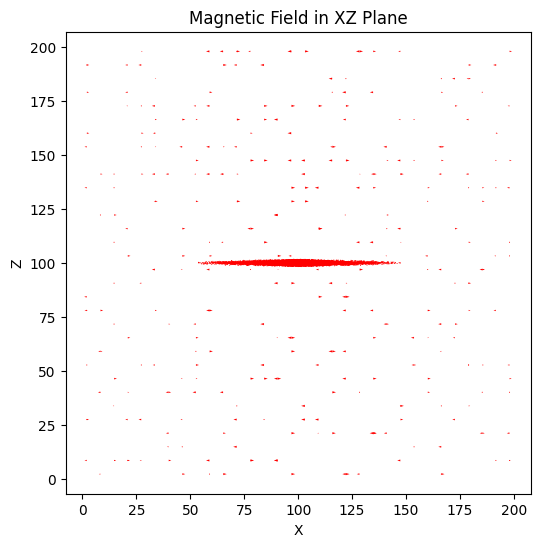


Processing V15_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 2000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1282767  147000 1000000       0       0       0]
NumPart_Total [1282767  147000 1000000       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1282767
Gas particle coordinate ranges:
x:  20.0 1980.0
y:  22.0 1982.0
z:  21.0 1981.0


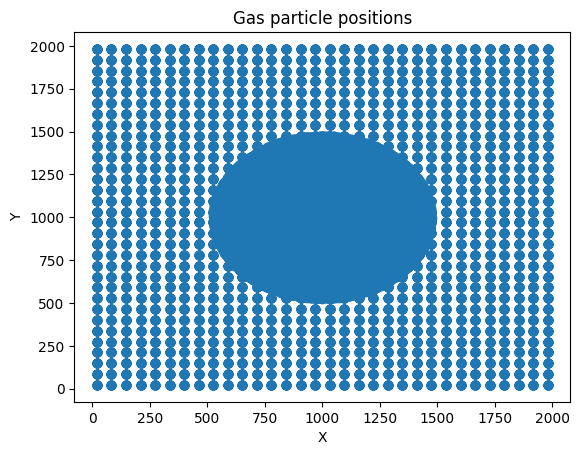

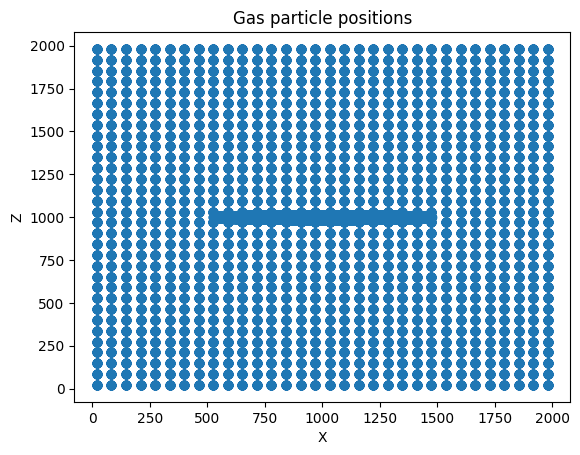


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 9987060.0
BH particle mass: 19986992.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1282756 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  25027564442.85657
mean disk_density (g cm-3):  9.173356e-25
mean disk_ndensity (cm-3):  0.39174387
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1208159 particles in disk with radii [ 0 40] kpc and half heights [0.  1.5] kpc
Total disk mass (M_sun):  24163316481.80246
mean disk_density (g cm-3):  9.730543e-25
mean disk_ndensity (cm-3):  0.41553852
mean disk_temp (K):  10342.364

 Check CGM properties...
Temperature mask: 1282767 particles in region with temperature above 1 K
CGM mask: 74597 particles in region with radii [ 40 100] kpc

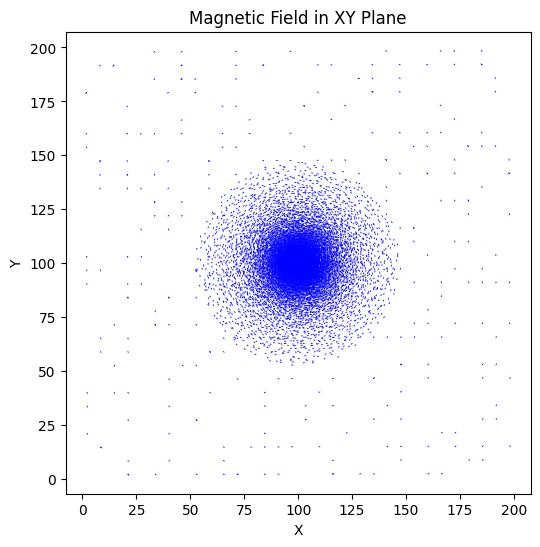

Average magnetic field magnitude: 1.0000001044244144e-12 G


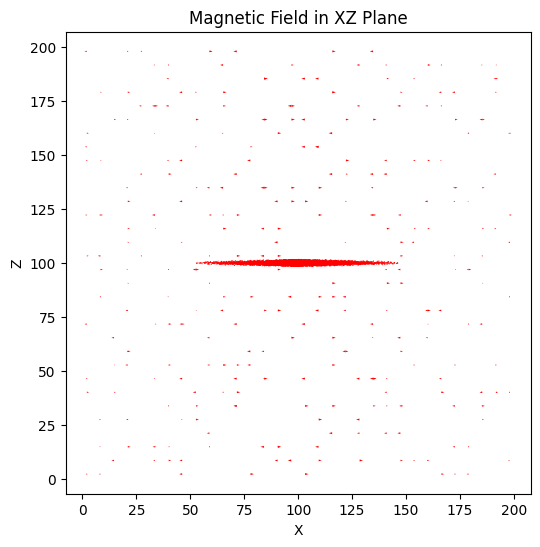


Processing V16_000...
DustTemperature successfully updated.
ChemicalAbundances successfully updated.
Re-centering coordinates.
MagneticField successfully updated.

HEADER:
BoxSize 2000.0
MassTable [0. 0. 0. 0. 0. 0.]
NumFilesPerSnapshot 1
NumPart_ThisFile [1282767  147000 1000000       0       0       0]
NumPart_Total [1282767  147000 1000000       0       0       0]
Redshift 0.0
Time 0.0

GAS PARTICLES:
Number of gas particles:  1282767
Gas particle coordinate ranges:
x:  20.0 1980.0
y:  22.0 1982.0
z:  21.0 1981.0


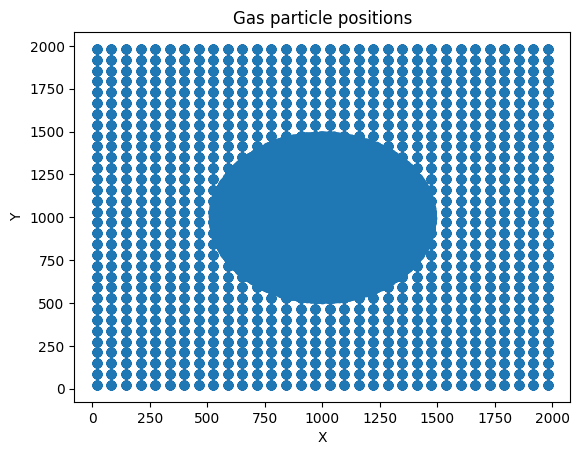

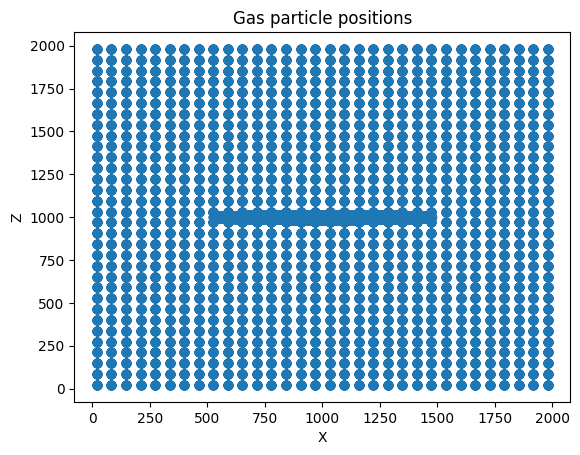


Number of gas particles outside boxsize: 0

Mean dark matter particle mass: 9987059.0
BH particle mass: 19986992.0

 Check sim properties...
Mass: found 0 NaN values
Mass: found 0 Inf values
Density: found 0 NaN values
Density: found 0 Inf values
InternalEnergy: found 0 NaN values
InternalEnergy: found 0 Inf values
Disk mask: 1282756 particles in disk with radii [  0 200] kpc and half heights [  0 200] kpc
Total disk mass (M_sun):  25027568544.212437
mean disk_density (g cm-3):  9.173356e-25
mean disk_ndensity (cm-3):  0.391744
mean disk_temp (K):  10342.365

 Check disk properties...
Disk mask: 1208159 particles in disk with radii [ 0 40] kpc and half heights [0.  1.5] kpc
Total disk mass (M_sun):  24163316481.80246
mean disk_density (g cm-3):  9.730544e-25
mean disk_ndensity (cm-3):  0.41553846
mean disk_temp (K):  10342.364

 Check CGM properties...
Temperature mask: 1282767 particles in region with temperature above 1 K
CGM mask: 74597 particles in region with radii [ 40 100] kpc 

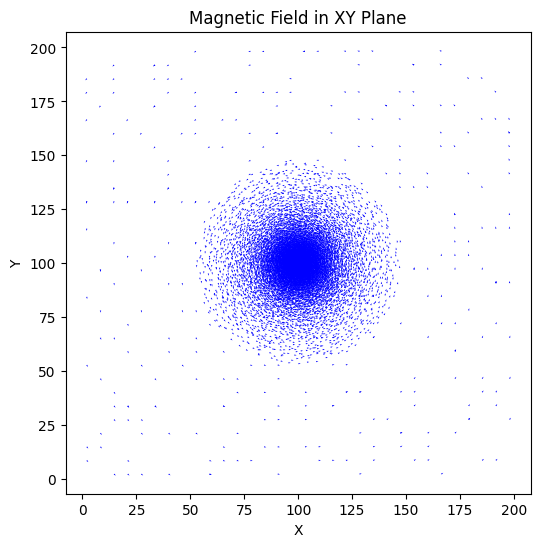

Average magnetic field magnitude: 1.0000001044244144e-12 G


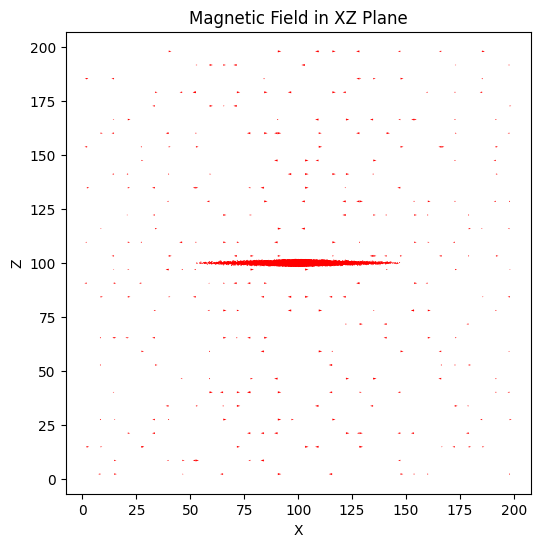

In [ ]:
for n in np.arange(1, 17, 1):

    print(f"\nProcessing V{n}_000...")

    boxsize = boxsizes[(n-1) // 4]
    bh_mass = bh_masses[(n-1) // 4]
    radius = radii[(n-1) // 4]
    height = heights[(n-1) // 4]

    filepath = os.path.join(run_path, f"snapshots_V{n}", f"V{n}_000.hdf5")

    # add additional properties to the ICs
    # (Arepo will skip B field on read if started from IC unless behavior has been changed in snap_io.cc (search for 'MHD_SEEDFIELD'))
    add_dust_temperature(filepath, dust_temperature_in_K=2.0)
    add_chem_abundances(filepath, chem_abundances='NL97')
    add_magnetic_field(filepath, B0_in_gauss=1e-12, direction='toroidal')

    check_ics(filepath, boxsize=boxsize, unit_length=3.0856e20, unit_mass=1.991e33, unit_velocity=1.0e5)

    print("\n Check sim properties...")
    sim_mass, sim_ndensity, sim_temp = get_sim_mass_ndensity_temp(filepath, radii_in_kpc=[0, 300], half_heights_in_kpc=[0, 200])

    print("\n Check disk properties...")
    disk_mass, disk_ndensity, disk_temp = get_disk_mass_ndensity_temp(filepath, radii_in_kpc=[0, radius], half_heights_in_kpc=[0, height])

    print("\n Check CGM properties...")
    # cgm_mass, cgm_ndensity, cgm_temp = get_cgm_mass_ndensity_temp(filepath, radii_in_kpc=[radius, 100], half_heights_in_kpc=[height, 100])
    # set_CGM_ndensity(filepath, CGM_ndensity=1e-4, density_threshold_cgs=1e-37, radii_in_kpc=[radius, 100], half_heights_in_kpc=[height, 100])
    set_CGM_temperature(filepath, CGM_temp_K = 1e6, temp_threshold_K = 1, radii_in_kpc=[radius, 100], half_heights_in_kpc=[height, 100])
    cgm_mass, cgm_ndensity, cgm_temp = get_cgm_mass_ndensity_temp(filepath, radii_in_kpc=[radius, 100], half_heights_in_kpc=[height, 100])

    # check magnetic field
    plot_field(filepath, plane='XY')
    plot_field(filepath, plane='XZ')

# run from snapshot 000 (using option 2)